# Code for making predictions with and without news features

## Libraries/Data required

In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score

# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/"  # Define data path

In [10]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


C:\Users\barta\AppData\Local\Temp\ipykernel_20084\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


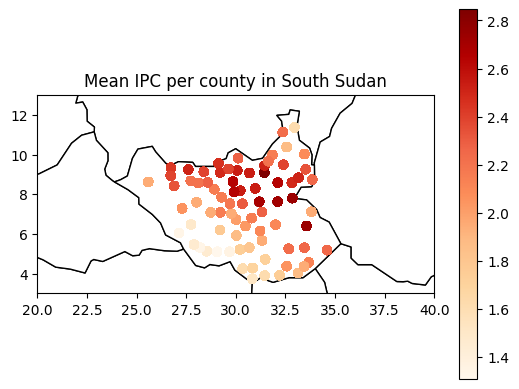

In [11]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [12]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [13]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [14]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [15]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [16]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [17]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

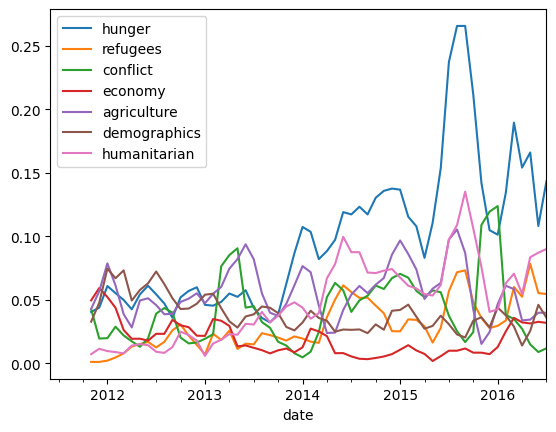

In [18]:
# country wide news features
topics = ["hunger", "refugees",
          "conflict", "economy",
          "agriculture", "demographics",
          "humanitarian"]
news_features = create_news_features(topics)

news_features.plot();

<Axes: xlabel='ipc', ylabel='Share of total articles'>

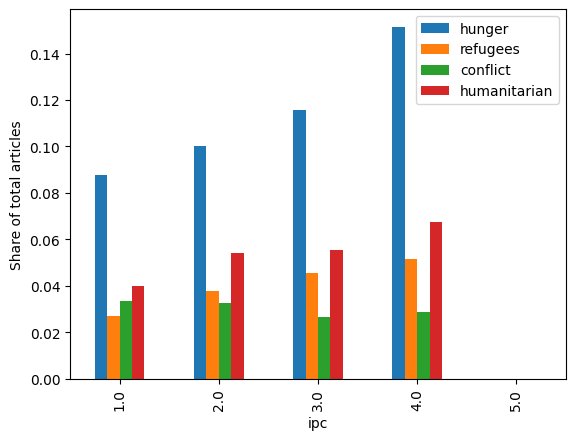

In [19]:
# Get the mean share of articles per ipc for the different topics
y = df[["ipc"]]

combined = (

    pd.DataFrame(y["ipc"])

    .join(news_df.groupby(["date"])["hunger"].mean())

    .join(news_df.groupby(["date"])["refugees"].mean())

    .join(news_df.groupby(["date"])["conflict"].mean())

    .join(news_df.groupby(["date"])["humanitarian"].mean())
)



# Plot the mean share of articles per ipc value for the different topics

combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(

    kind="bar", ylabel="Share of total articles"
)

## Predicting using news features

In [20]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [21]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ipc   No. Observations:                  962
Model:                            GLM   Df Residuals:                      955
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24.964
Date:                Fri, 10 Nov 2023   Deviance:                       44.875
Time:                        19:42:05   Pearson chi2:                     298.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1231
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
count_violence     0.3722      0.526      0.

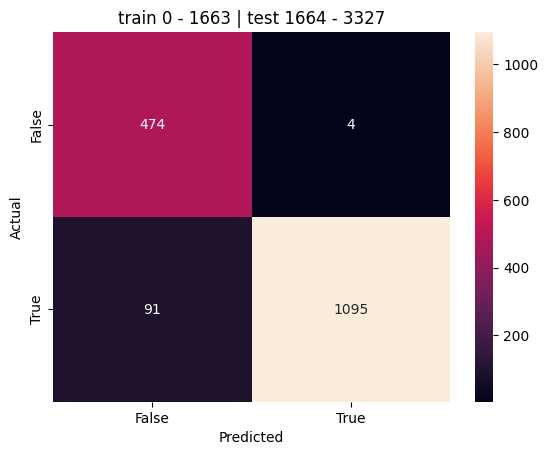

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                            GLM   Df Residuals:                     2612
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -499.52
Date:                Fri, 10 Nov 2023   Deviance:                       871.05
Time:                        19:42:05   Pearson chi2:                 3.82e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2687
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
count_violence     0.1857      0.076      2.

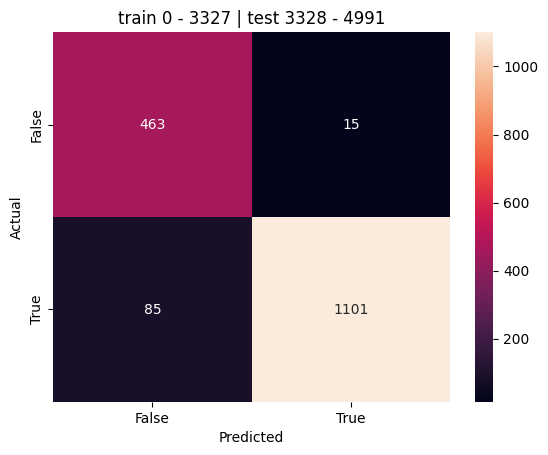

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                            GLM   Df Residuals:                     4276
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -937.00
Date:                Fri, 10 Nov 2023   Deviance:                       1607.9
Time:                        19:42:06   Pearson chi2:                 4.38e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2709
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
count_violence     0.1002      0.025      3.

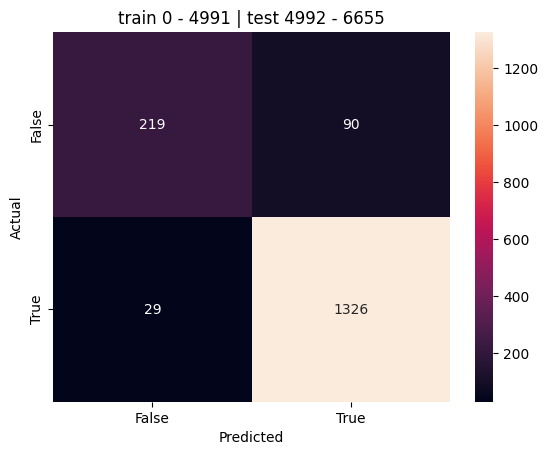

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                            GLM   Df Residuals:                     5940
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1489.6
Date:                Fri, 10 Nov 2023   Deviance:                       2535.7
Time:                        19:42:06   Pearson chi2:                 5.66e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3533
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
count_violence     0.0633      0.023      2.

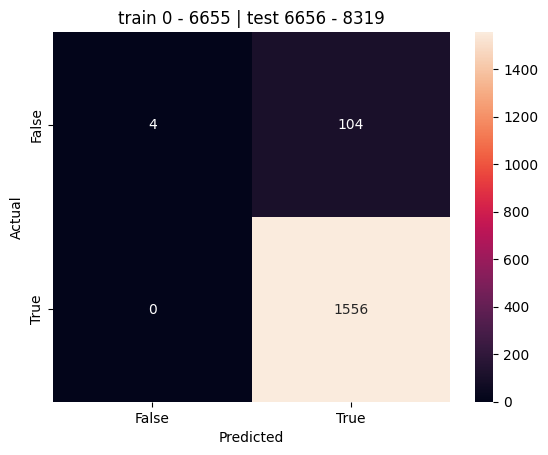

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                            GLM   Df Residuals:                     7604
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2085.6
Date:                Fri, 10 Nov 2023   Deviance:                       3485.5
Time:                        19:42:06   Pearson chi2:                 6.30e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4744
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
count_violence     0.0987      0.017      5.

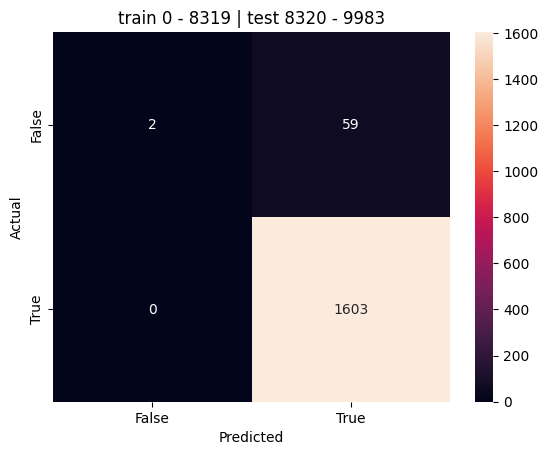

Mean Acc: 0.94
Mean Precision: 0.96
Mean Recall: 0.97
Mean F1: 0.96
Mean Balanced Acc: 0.76


<Figure size 640x480 with 0 Axes>

In [22]:



test_cols = ['count_violence', 'ndvi_anom', 
             'food_price_idx', 'ipc_lag_1',
             'ipc_lag_2', 'ipc_lag_3',
             "hunger", "refugees",
             "conflict", "economy",
             "agriculture", "demographics",
             "humanitarian" ]
df[topics] = df[topics].fillna(0)
df.sort_index(level=0, inplace=True)
df = df.iloc[df['ipc'].notnull().argmax():].copy()


X = df.loc[:, test_cols] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data
test_cols.append('const')

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores
f1_values = list() # Initinalize empty lists to score f1 scores
precision_valus = list() # Initinalize empty lists to score precision scores
recall_values = list() # Initinalize empty lists to score recall scores
balanced_acc_values = list() # Initinalize empty lists to score balanced accuracy scores
for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.GLM(y_train, X_train[test_cols], family=sm.families.Binomial(), missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[test_cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list
    precision_valus.append(precision_score(y_val, y_pred)) # Append precision to list
    recall_values.append(recall_score(y_val, y_pred)) # Append recall to list
    f1_values.append(f1_score(y_val, y_pred)) # Append f1 to list
    balanced_acc_values.append(balanced_accuracy_score(y_val, y_pred)) # Append balanced accuracy to list
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc
print(f"Mean Precision: {np.mean(precision_valus):.2f}") # Print Precision
print(f"Mean Recall: {np.mean(recall_values):.2f}") # Print Recall
print(f"Mean F1: {np.mean(f1_values):.2f}") # Print F1
print(f"Mean Balanced Acc: {np.mean(balanced_acc_values):.2f}") # Print Balanced Acc